### Preliminaries: 

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix)
import sys

#this will make our arrays print in their entirety instead of truncating
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
#GUIDE: 
    #og_df = original df with all data *don't edit* 
    #df = edited df 
    #sex_df = df sorted by sex (with both prompts) 
    # **gen_df = subset of data with only gender x general prompt **
    # ** ang_df = subset of data with only gender x anger prompt **
    
#This may be way too many dataframes, I'm sorry. The main ones we should be using for now should be the last two 

In [3]:
og_df = pd.read_csv("proj_responses.csv")  #load in dataframe 

In [4]:
df = og_df.copy()   #make copy of df to manipulate 

### Wrangling: 

In [5]:
df = df.drop('Timestamp', axis = 1) #remove timestamp column 
df = df.drop(index = [2, 42]) 

#ignore error msgs 

In [6]:
## binarizing gender column: men = 0, women = 1 
sex_df = df.sort_values("Sex").reset_index()  #sort by gender 
sex_df.loc[0:20, 'Sex'] = 1  #rows 0-20 = 1 for woman
sex_df.loc[21:, 'Sex'] = 0 #rows 21 to end = 0 for man

In [7]:
#making df for general prompt and anger prompt: 
gen_df = sex_df[["Sex", "General Prompt"]]
ang_df = sex_df[["Sex", "Anger Prompt"]]

### Making the Gendered Prompts Columns

In [8]:
## all female gen 
fem_gen = gen_df[0:21]

In [9]:
## all male gen 
men_gen = gen_df[21:]

In [10]:
## all female anger 
fem_anger = ang_df[0:21]

In [11]:
## all male anger 
men_anger = ang_df[21:]

### Making Train/Test

In [12]:
## General Train Set
gen_train = pd.concat([fem_gen[:17], men_gen[:17]])

In [13]:
## General Test Set
gen_test = pd.concat([fem_gen[17:], men_gen[17:]])

In [14]:
## Anger Train Set
ang_train = pd.concat([fem_anger[:17], men_anger[:17]])

In [15]:
## Anger Test Set
ang_test = pd.concat([fem_anger[17:], men_anger[17:]])

## Data Visualizations: 

/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


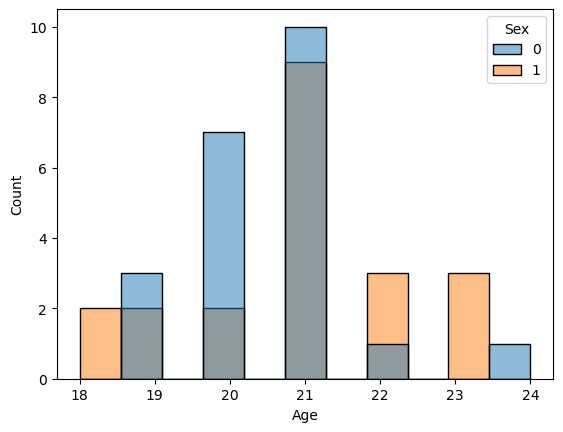

In [16]:
#age hist
sns.histplot(data = sex_df, x = "Age", color = 'pink', hue = 'Sex');

/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


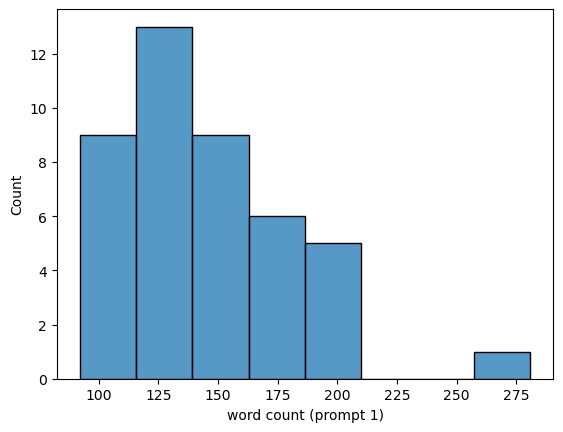

In [17]:
#gen prompt hist
sns.histplot(data= sex_df, x = "word count (prompt 1)");

/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


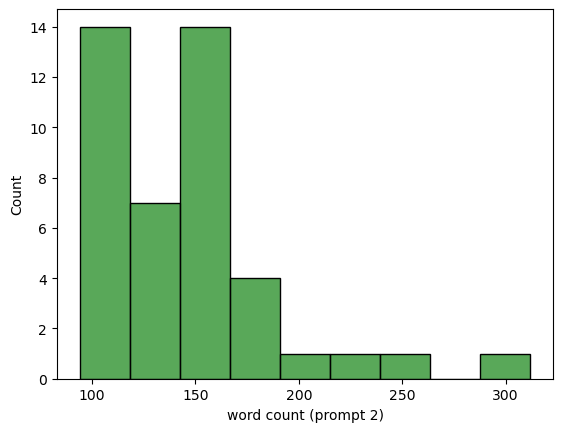

In [18]:
#anger prompt hist
sns.histplot(data= sex_df, x = "word count (prompt 2)", color = 'forestgreen');

### Processing the Text

In [19]:
#import packages
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
ttokenizer = TweetTokenizer() 

In [20]:
#tokenize our general train responses
gen_train_prompts= [] 
for entry in gen_train["General Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    gen_train_prompts.append(tokenized_entry)

In [21]:
#tokenize our general test responeses
gen_test_prompts= [] 
for entry in gen_test["General Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    gen_test_prompts.append(tokenized_entry)

In [22]:
#tokenize our angry train responeses
ang_train_prompts = [] 
for entry in ang_train["Anger Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    ang_train_prompts.append(tokenized_entry)

In [23]:
#tokenize our angry test responeses
ang_test_prompts = [] 
for entry in ang_test["Anger Prompt"]: 
    tokenized_entry = ttokenizer.tokenize(entry)
    ang_test_prompts.append(tokenized_entry)

### Cleaning entries

In [24]:
#function for removing stop words: 
def remove_stop_words(df): 
    responses_without_stop = []
    
    for entry in df:
        text_with_stop_words = entry
        text_without_stop_words = [word for word in text_with_stop_words if word not in stopwords.words("english")]
        responses_without_stop.append(text_without_stop_words)
    return(responses_without_stop)

In [25]:
## function for unigram freq: 
def unigram_frequency(list): 
    #create lists to store unigram frequency
    unigram_freqs = []

    #for each entry, calculate n-grams and frequency, then store in respective list 
    for entry in list: 
        unigram_frequency_distribution = nltk.FreqDist(entry)
        unigrams = [ (unigram, unigram_frequency_distribution[unigram]) for unigram in unigram_frequency_distribution ]
        unigram_freqs.append(unigrams)
    return unigram_freqs

In [26]:
# function for unigram vocab: 
def unigram_vocab(freqs_list):
    vocab = [] 

    #for each entry, add every unigram to the unigram vocab
    for entry in freqs_list:
        for x in entry:
            unigram = x[0]
            vocab.append(unigram)
    return vocab

In [27]:
# function to create feature array based on vocab and freq of unigram
def unigram_features(data,vocab):
    features = []
    
    for entry in data: 
        freqs = [0] * len(vocab)
        #for each unigram in tweet, replace frequency in instance list with frequency
        for x in entry:
            unigram = x[0]
            freq = x[1]
            freqs[vocab.index(unigram)] = freq
        #append instance frequency list to features array
        features.append(freqs)
    
    return features

### Unigram Feature: 
- unigram_frequency
- unigram_vocab
- append into master list 
- unigram_features 

In [28]:
## removing stop words from all dfs: 
gen_train_list = remove_stop_words(gen_train_prompts)
gen_test_list = remove_stop_words(gen_test_prompts)
ang_train_list = remove_stop_words(ang_train_prompts)
ang_test_list = remove_stop_words(ang_test_prompts)

In [29]:
#Making frequency list of each individual set
gen_train_freq = unigram_frequency(gen_train_list) 
gen_test_freq = unigram_frequency(gen_test_list) 
ang_train_freq = unigram_frequency(ang_train_list) 
ang_test_freq = unigram_frequency(ang_test_list) 

In [30]:
#Making vocab list of each individual set
gen_train_vocab = unigram_vocab(gen_train_freq) 
gen_test_vocab = unigram_vocab(gen_test_freq) 
ang_train_vocab = unigram_vocab(ang_train_freq) 
ang_test_vocab = unigram_vocab(ang_test_freq) 

In [31]:
#Making master list of each vocab list 
vocabularies = [gen_train_vocab, gen_test_vocab, ang_train_vocab, ang_test_vocab]

# Master list to store all vocabularies
master_list = []

# Loop through each vocabulary and append it to the master_list
for vocab in vocabularies:
    master_list.extend(vocab)

master_list = sorted(list(set(master_list)))

In [32]:
#Making features arrays 
gen_train_feat = unigram_features(gen_train_freq, master_list) 
gen_test_feat = unigram_features(gen_test_freq, master_list) 
ang_train_feat = unigram_features(ang_train_freq, master_list) 
ang_test_feat = unigram_features(ang_test_freq, master_list) 

### Making the Labels: 

In [33]:
gen_train_labels = gen_train['Sex'].tolist()
gen_test_labels = gen_test['Sex'].tolist()
ang_train_labels = ang_train['Sex'].tolist()
ang_test_labels = ang_test['Sex'].tolist()

### Predictive Model based on Unigrams

The confusion matrix displays the following information for us:

|  | **Prediction = 0/Male**   | **Prediction = 1/Female** |
|  ----   | -------- | ------- |
|**Actual = 0/Male** | True Male  | False Female  |
| **Actual = 1/Male**|False Male | True Female    |

We will train a logistic regression model for the general prompt responses and anger prompt responses, then test both models on a respective test set. We will also compute accuracy scores and print a confusion matrix to analyze further. 

In [34]:
#gen model and test

#using L2 regularisation
lm_log_gen = LogisticRegression().fit(gen_train_feat, gen_train_labels)

test_pred = lm_log_gen.predict(gen_test_feat)  
print(test_pred)
test_pred_round = np.round(test_pred)

#print accuracy and confusion matrix
print('Test accuracy: ', accuracy_score(gen_test_labels, test_pred_round))
print ("Confusion Matrix : \n", confusion_matrix(gen_test_labels, test_pred_round) ) 

[1 0 1 1 0 0 0 0 1]
Test accuracy:  0.7777777777777778
Confusion Matrix : 
 [[4 1]
 [1 3]]


In [35]:
#anger model and test
lm_log_ang = LogisticRegression().fit(ang_train_feat, ang_train_labels)

test_pred = lm_log_gen.predict(ang_test_feat)  
print(test_pred)
test_pred_round = np.round(test_pred)

#print accuracy and confusion matrix
print('Test accuracy: ', accuracy_score(ang_test_labels, test_pred_round))
print ("Confusion Matrix : \n", confusion_matrix(ang_test_labels, test_pred_round) ) 

[1 0 0 1 0 1 0 0 1]
Test accuracy:  0.5555555555555556
Confusion Matrix : 
 [[3 2]
 [2 2]]


In [36]:
from nltk.tag import pos_tag

def count_pos(tokenized_text): 
    text_as_pos = []
    pos_list = pos_tag(tokenized_text)
    for entry in pos_list:
        pos = entry[1]
        text_as_pos.append(pos)
    return text_as_pos

def count_pos_list(tokenized_text_list):
    all_pos = []   
    for text in tokenized_text_list:
        text_as_pos = []
        pos_list = pos_tag(text)
        for entry in pos_list:
            pos = entry[1]
            text_as_pos.append(pos)
        
        all_pos.append(text_as_pos) 
    return all_pos


In [37]:
gen_train_pos = unigram_frequency(count_pos_list(gen_train_prompts))
gen_test_pos = unigram_frequency(count_pos_list(gen_test_prompts))
ang_train_pos = unigram_frequency(count_pos_list(ang_train_prompts))
ang_test_pos = unigram_frequency(count_pos_list(ang_test_prompts))

In [38]:
gen_train_pos_vocab = unigram_vocab(gen_train_pos)
gen_test_pos_vocab = unigram_vocab(gen_test_pos)
ang_train_pos_vocab = unigram_vocab(ang_train_pos)
ang_test_pos_vocab = unigram_vocab(ang_test_pos)

In [39]:
#Making master list of each vocab list 
pos_vocabularies = [gen_train_pos_vocab, gen_test_pos_vocab, ang_train_pos_vocab, ang_test_pos_vocab]

# Master list to store all vocabularies
master_pos_list = []

# Loop through each vocabulary and append it to the master_list
for pos_vocab in pos_vocabularies:
    master_pos_list.extend(pos_vocab)

master_pos_list = sorted(list(set(master_pos_list)))

In [40]:
gen_train_pos_feat = unigram_features(gen_train_pos, master_pos_list)
gen_test_pos_feat = unigram_features(gen_test_pos, master_pos_list)
ang_train_pos_feat = unigram_features(ang_train_pos, master_pos_list)
ang_test_pos_feat = unigram_features(ang_test_pos, master_pos_list)

In [41]:
len(gen_train_pos_feat)
len(gen_train_labels)

34

In [42]:
#gen model and test

#using L2 regularisation
lm_log_gen_pos = LogisticRegression().fit(gen_train_pos_feat, gen_train_labels)

test_pred = lm_log_gen_pos.predict(gen_test_pos_feat)  
print(test_pred)
test_pred_round = np.round(test_pred)

#print accuracy and confusion matrix
print('Test accuracy: ', accuracy_score(gen_test_labels, test_pred_round))
print ("Confusion Matrix : \n", confusion_matrix(gen_test_labels, test_pred_round) ) 

[1 0 1 1 0 0 0 1 1]
Test accuracy:  0.6666666666666666
Confusion Matrix : 
 [[3 2]
 [1 3]]


/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
#ang model and test

#using L2 regularisation
lm_log_ang_pos = LogisticRegression().fit(ang_train_pos_feat, ang_train_labels)

test_pred = lm_log_ang_pos.predict(ang_test_pos_feat)  
print(test_pred)
test_pred_round = np.round(test_pred)

#print accuracy and confusion matrix
print('Test accuracy: ', accuracy_score(ang_test_labels, test_pred_round))
print ("Confusion Matrix : \n", confusion_matrix(ang_test_labels, test_pred_round) ) 

[1 0 0 0 0 0 0 0 1]
Test accuracy:  0.5555555555555556
Confusion Matrix : 
 [[4 1]
 [3 1]]


/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
with open("data/a1/warriner_valence.csv", "r", encoding ="utf8") as f:
    all_text = f.read() # read in the whole file.

# split into each lines, by splitting on the new-line character
all_lines = all_text.split('\n')

warriner_dict = {}
for this_line in all_lines:
    this_word, val_score = this_line.split(',')
    warriner_dict[this_word] = val_score

def warriner_score (text):

    t = text.split()

    warriner_list = [0] #instantiate list so there is at least one element in the list 

    for word in t:
        if word in warriner_dict:
            score = float(warriner_dict[word]) #convert warriner score to numeric
            warriner_list.append(score)

    if warriner_list != [0]:
        warrinerScore = sum(warriner_list) / (len(warriner_list) - 1) #calculate the warriner score excluding initial zero
    else: warrinerScore = 0 #if no words in review are in warriner list, set warrinerScore = 0

    return warrinerScore

def warriner_score_list(prompts):
    ws_list = []
    for entry in prompts:
        ws = warriner_score(entry)
        ws_list.append(ws)
    return ws_list

In [45]:
fem_gen_valence = warriner_score_list(fem_gen["General Prompt"])
fem_ang_valence = warriner_score_list(fem_anger["Anger Prompt"])
men_gen_valence = warriner_score_list(men_gen["General Prompt"])
men_ang_valence = warriner_score_list(men_anger["Anger Prompt"])

## Testing

In [47]:
print(np.var(fem_gen_valence), np.var(men_gen_valence))


0.09978038915042596 0.08248987510402586


In [49]:
import scipy.stats as stats 


In [50]:
stats.ttest_ind(fem_gen_valence, men_gen_valence, equal_var= False)



TtestResult(statistic=0.3958936540134736, pvalue=0.6942782675626495, df=40.17377098611939)

In [51]:
stats.ttest_ind(fem_ang_valence, men_ang_valence, equal_var= False)


TtestResult(statistic=0.23508086574664244, pvalue=0.8153162064594963, df=40.998154368410944)

In [73]:
from scipy.stats import shapiro


In [75]:
statistic, p_value = shapiro(men_gen_valence)

print("Shapiro-Wilk Test Statistic:", statistic)
print("p-value:", p_value)


Shapiro-Wilk Test Statistic: 0.9277408719062805
p-value: 0.11009607464075089


### Visualizations: 
- [x] word cloud
- [x] output of matrix
- [x] t-test vis

**put in results section of paper** 

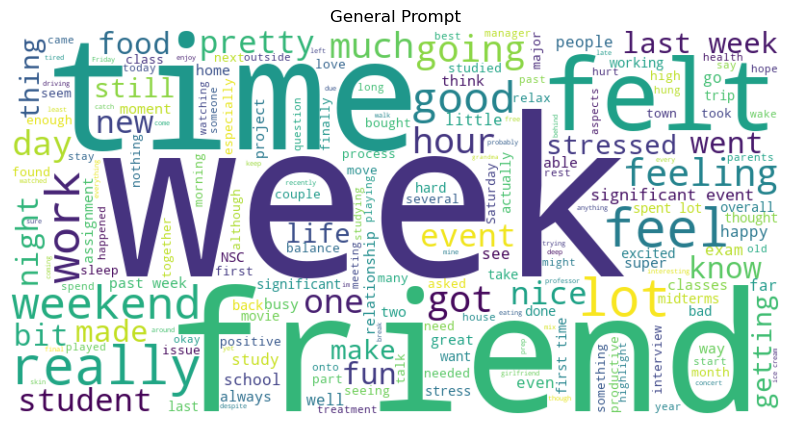

In [136]:
gen_list = []
for entry in gen_train_list: 
    for word in entry: 
        gen_list.append(word)
    gen_string = ' '.join(gen_list)

        
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(gen_string)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('General Prompt')
plt.show()

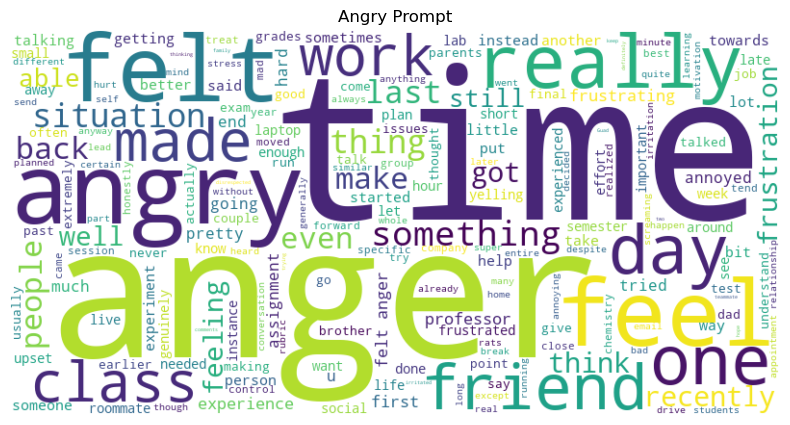

In [134]:
ang_list = []
for entry in ang_train_list: 
    for word in entry: 
        ang_list.append(word)
    ang_string = ' '.join(ang_list)

        
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ang_string)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Angry Prompt')
plt.show()

/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


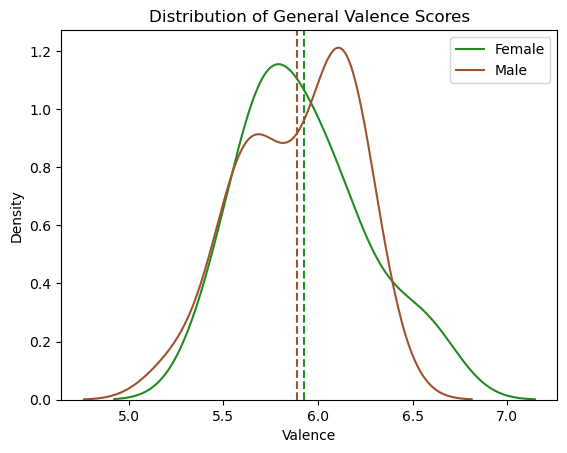

In [96]:
# t-test visualization 
fem_gen_mean = np.mean(fem_gen_valence)
men_gen_mean = np.mean(men_gen_valence)


sns.kdeplot(data=fem_gen_valence, label='Female', color='forestgreen')
plt.axvline(x=fem_gen_mean, color='forestgreen', linestyle='--')  # Adjust x=3 to your desired position


sns.kdeplot(data=men_gen_valence, label='Male', color='#A0522D')
plt.axvline(x=men_gen_mean, color='#A0522D', linestyle='--')  # Adjust x=3 to your desired position

# Set plot title and labels
plt.title('Distribution of General Valence Scores')
plt.xlabel('Valence')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()

#plt.savefig('gen_valence_dist.png')



/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ruthcarter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


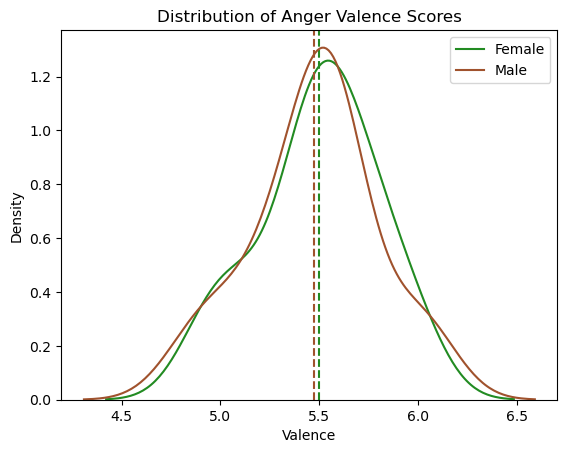

In [99]:
fem_ang_mean = np.mean(fem_ang_valence)
men_ang_mean = np.mean(men_ang_valence)


sns.kdeplot(data=fem_ang_valence, label='Female', color='forestgreen')
plt.axvline(x=fem_ang_mean, color='forestgreen', linestyle='--')  # Adjust x=3 to your desired position


sns.kdeplot(data=men_ang_valence, label='Male', color='#A0522D')
plt.axvline(x=men_ang_mean, color='#A0522D', linestyle='--')  # Adjust x=3 to your desired position

# Set plot title and labels
plt.title('Distribution of Anger Valence Scores')
plt.xlabel('Valence')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()

##plt.savefig('gen_valence_dist.png')
